# The machine learning script for "Structure-Based Prediction of Enzyme Substrate Scope with Machine Learning: Application to Bacterial Nitrilases"
Written by [Zhongyu Mou](https://github.com/ZhongyuMou)

Please cite [place holder](link) when using this script.

## Data inspection

In [1]:
#load pandas and numpy modules
import os 
import pandas as pd
import numpy as np
%matplotlib inline
 
#read raw data (here we used 50% concentration data, 25% conc. data is available on 'neu25').
df = pd.read_excel('nitrilase_descriptors.xlsx',sheet_name = 'neu50').copy()
print(df.shape)

df.head(5)

(240, 146)


,protein,nitrile class,nitriles,ZINC ID,activity,interface_delta_X,fa_atr,fa_elec,fa_rep,fa_sol,...,ISA,Xi,Ap,Phi,Psi,Pa,Pb,Pt,DGLJ,DGtor
0,1a1,Aromatic,4-Aminobenzonitrile,152697,0.716,-12.808,-17.008,-0.564,4.762,7.619,...,0.476,0.467,0.529,0.619,0.656,0.543,0.565,0.550,0.705,0.711
1,1a1,Arylaliphatic,4-Nitrophenylacetonitrile,154682,0.000,-12.572,-12.752,-0.501,1.421,6.467,...,0.475,0.470,0.528,0.614,0.664,0.539,0.567,0.549,0.695,0.703
2,1a1,Aromatic,4-(Dimethylamino)benzonitrile,155390,4.363,-11.979,-22.038,0.104,6.490,5.492,...,0.476,0.467,0.529,0.621,0.661,0.543,0.565,0.550,0.711,0.701
3,1a1,Aromatic,4-Chlorobenzonitrile,157255,3.998,-10.293,-18.752,-0.017,5.785,6.069,...,0.476,0.467,0.528,0.611,0.670,0.539,0.564,0.549,0.705,0.707
4,1a1,Aromatic,"2,6-Dichlorobenzonitrile",157318,0.000,-9.036,-11.809,-0.275,2.007,5.476,...,0.476,0.467,0.528,0.610,0.667,0.539,0.564,0.549,0.703,0.677


In [2]:
#check if this dataframe is missing any values
#check the columns and the data type of each columns
if df.isnull().values.any():
    print ('There are missing values! Check and correct before proceed!')
    raise
else:
    print('There is no missing values in this dataframe.\n')

#inspect data
#print('check data type for each columns:')
#df.info(verbose=True) 

There is no missing values in this dataframe.



#### Columns of this dataframe
1. `protein`:enzyme
2. `nitrile class`: susbtrate class
3. `nitriles`: substrate name
4. `ZINC ID`: substrate [ZINC15](https://zinc.docking.org/) ID
5. `activity`: experimental activity
6. descriptors for machine learning:
    1. Docking (RosettaLigand)
    2. QM descriptors (Gaussian16)
    3. Small molecule descriptors ([MOE](http://www.cadaster.eu/sites/cadaster.eu/files/challenge/descr.htm))
    4. Active site descriptors ([ProtDcal](https://protdcal.zmb.uni-due.de/))

#### Create a (version of) folder to save images

In [3]:
#change the version to avoid overwrite
img_dir = './img_v1/' 

if not os.path.isdir(img_dir):
    print('Creating image folder {}. Figures will be saved here'.format(img_dir))
    os.mkdir(img_dir)
else:
    print('Image folder "{}" already exist, figures created will overwrite!'.format(img_dir))

Image folder "./img_v1/" already exist, figures created will overwrite!


### Setting cutoff for experimental values for binary classification
We set a cutoff here to set a binary classification as **inactive** and **active** at a specific threshold.
    
With a larger dataset it's possible to assign multiple classes such as **inactive**, **active** and **moderately active**.

In [4]:
#assign cutoff using concentration of 1 mM, 2 mM ,3 mM ,4 mM.
for i in range(1,5):
    cut = 'cutoff_'+ str(i)
    df[cut] = df['activity'].apply(lambda x:'inactive' if x < i else 'active')

#rearrange data, put cutoff in the first four 
cols = df.columns.tolist()
cols = cols[-4:] + cols[:-4]
df_cut = df[cols]
df_cut.head()

,cutoff_1,cutoff_2,cutoff_3,cutoff_4,protein,nitrile class,nitriles,ZINC ID,activity,interface_delta_X,...,ISA,Xi,Ap,Phi,Psi,Pa,Pb,Pt,DGLJ,DGtor
0,inactive,inactive,inactive,inactive,1a1,Aromatic,4-Aminobenzonitrile,152697,0.716,-12.808,...,0.476,0.467,0.529,0.619,0.656,0.543,0.565,0.550,0.705,0.711
1,inactive,inactive,inactive,inactive,1a1,Arylaliphatic,4-Nitrophenylacetonitrile,154682,0.000,-12.572,...,0.475,0.470,0.528,0.614,0.664,0.539,0.567,0.549,0.695,0.703
2,active,active,active,active,1a1,Aromatic,4-(Dimethylamino)benzonitrile,155390,4.363,-11.979,...,0.476,0.467,0.529,0.621,0.661,0.543,0.565,0.550,0.711,0.701
3,active,active,active,inactive,1a1,Aromatic,4-Chlorobenzonitrile,157255,3.998,-10.293,...,0.476,0.467,0.528,0.611,0.670,0.539,0.564,0.549,0.705,0.707
4,inactive,inactive,inactive,inactive,1a1,Aromatic,"2,6-Dichlorobenzonitrile",157318,0.000,-9.036,...,0.476,0.467,0.528,0.610,0.667,0.539,0.564,0.549,0.703,0.677


### Plot classification results at different thresholds

          cutoff_1  cutoff_2  cutoff_3  cutoff_4
inactive       144       157       175       184
active          96        83        65        56


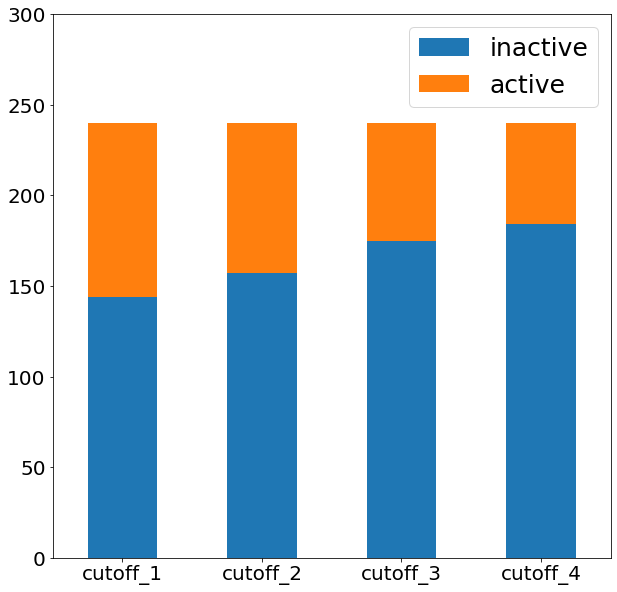

In [5]:
import matplotlib.pyplot as plt
freq = df_cut.iloc[:,0:4].apply(pd.value_counts)
print(freq)

plot = freq.transpose().plot(kind = 'bar', rot = 0 , ylim = (0,300),
                             stacked = True, figsize = (10,10), 
                             fontsize = 20).legend(loc=1, prop={'size': 25})
fig = plot.get_figure()
fig.savefig(img_dir + 'cutoff.png')

We decided to use `cutoff_2` to split **active** vs **inactive** enzyme-substrate pairs. As shown above, there is a 157/83 active-inactive split.

## Data preparation

### Remove highly correlated features.

# of features before drop: 141
# of features after drop: 61
# of features dropped: 80


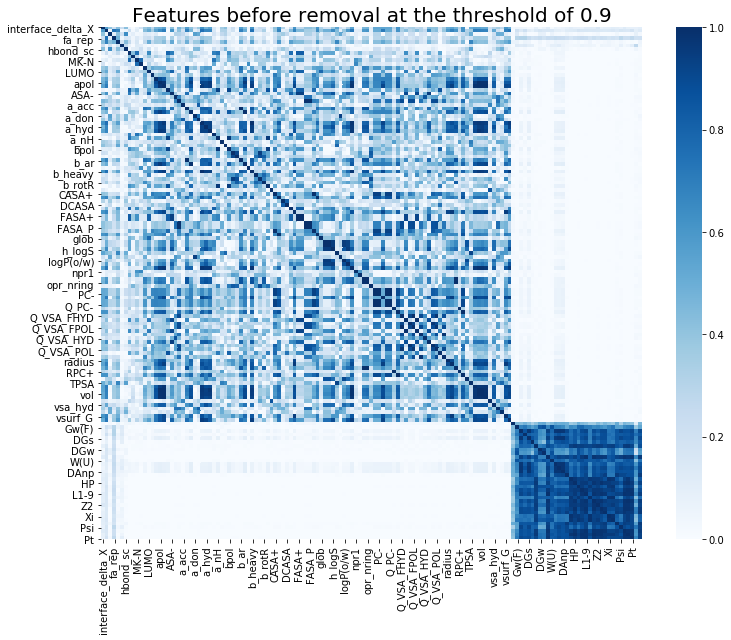

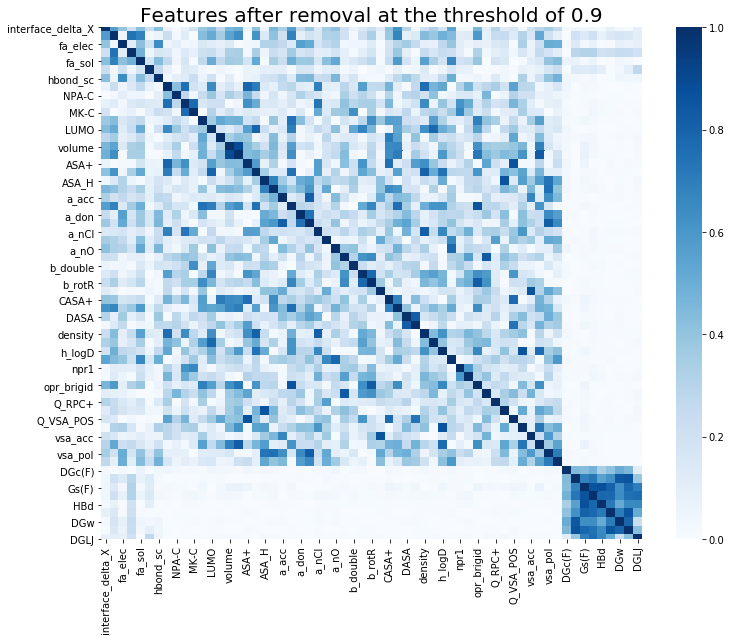

In [6]:
#remove highly correlated features (corr > 90%)
import seaborn as sns

#features
features_pre = df_cut.iloc[:,9:]

print('# of features before drop:', features_pre.shape[1])

#create correlation matrix
corr_matrix_before = features_pre.corr().abs()

#set a cutoff threshold (usually 0.9 or 0.85)
cut_th = 0.90

#plot heatmap before removing highly correlated features
f, ax = plt.subplots(figsize=(11, 9))
ax = sns.heatmap(corr_matrix_before, cmap = 'Blues')
plt.title('Features before removal at the threshold of {}'.format(cut_th),fontsize = 20)
plt.tight_layout()
plt.savefig(img_dir + 'corr_matrix_before.png')

#select upper triangle of correlation matrix
upper = corr_matrix_before.where(np.triu(np.ones(corr_matrix_before.shape), k=1).astype(np.bool))

#drop highly correlated features based on set threshold
to_drop = [column for column in upper.columns if any(upper[column] > cut_th)]
df_cut_cor = df_cut.drop(columns = to_drop)

#plot heatmap after removing highly correlated features
corr_matrix_after = df_cut_cor.iloc[:,9:].corr().abs()
f, ax = plt.subplots(figsize=(11, 9))
ax = sns.heatmap(corr_matrix_after, cmap = 'Blues')
plt.title('Features after removal at the threshold of {}'.format(cut_th),fontsize = 20)
plt.tight_layout()
plt.savefig(img_dir + 'corr_matrix_after.png')

print('# of features after drop:', features_pre.shape[1]-len(to_drop))
print('# of features dropped:', len(to_drop))

### Data scaling
Note this step may not necccesary for some methods such as tree-based methods.

In [7]:
#can also be achieved by using sklearn.preprocessing.scale
df_scaled = df_cut_cor.copy()
X = df_scaled.iloc[:,10:]
X = (X-X.mean())/X.std()
df_scaled.update(X)
df_scaled.head()

,cutoff_1,cutoff_2,cutoff_3,cutoff_4,protein,nitrile class,nitriles,ZINC ID,activity,interface_delta_X,...,vsurf_A,DGc(F),Gw(F),Gs(F),W(F),HBd,DGel,DGw,W(U),DGLJ
0,inactive,inactive,inactive,inactive,1a1,Aromatic,4-Aminobenzonitrile,152697,0.716,-12.808,...,-1.881488,1.870604,0.962699,0.134735,-0.102578,-0.189172,-0.163766,0.458813,0.101109,0.043488
1,inactive,inactive,inactive,inactive,1a1,Arylaliphatic,4-Nitrophenylacetonitrile,154682,0.000,-12.572,...,-1.277242,1.381273,0.138208,-0.115353,-0.720252,-0.019342,-0.415713,0.215636,0.040368,-0.127333
2,active,active,active,active,1a1,Aromatic,4-(Dimethylamino)benzonitrile,155390,4.363,-11.979,...,1.248084,1.870604,0.793572,0.222266,-0.036399,-0.189172,-0.271743,0.635669,0.101109,0.145981
3,active,active,active,inactive,1a1,Aromatic,4-Chlorobenzonitrile,157255,3.998,-10.293,...,0.897021,1.870604,0.561024,-0.065336,-0.234937,-0.189172,-0.073785,0.348278,0.040368,0.043488
4,inactive,inactive,inactive,inactive,1a1,Aromatic,"2,6-Dichlorobenzonitrile",157318,0.000,-9.036,...,0.428448,1.870604,0.032504,-0.190380,-0.830551,-0.189172,-0.235751,0.436706,0.040368,0.009324


### Data preparation summary
1. Check the integrity of the data. (no missing values, features of columns are numeric)
2. Set verious cutoffs to set binary classification. (or multiple classification)
3. Removed highly correlated data.
4. The final dataframe is saved as `df_scaled`. (features starts at **9th** column)

# Machine learning

## Find a proper oversampling method (for imbalanced data).
Base on a method published on Kaggle [website](https://www.kaggle.com/npramod/techniques-to-deal-with-imbalanced-data)

Note this step is not necessary if sample are balanced, i.e. the amount of **actives** are similar to the amount of **inactives** (e.g. `target.mean() ~ 0.5`).

In [8]:
from imblearn.over_sampling import RandomOverSampler, SMOTE, BorderlineSMOTE, SVMSMOTE, ADASYN
from imblearn.combine import SMOTEENN,SMOTETomek
from sklearn.metrics import recall_score,accuracy_score,confusion_matrix, f1_score, precision_score, auc,roc_auc_score,roc_curve, precision_recall_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

#features/target splitting
X = df_scaled.iloc[:,9:]
y = df_scaled['cutoff_2'].apply(lambda x: 0 if x == 'inactive' else 1)

#training/testing data splitting
#test oversampling on 75% of the data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.20, random_state = 888)

#helper function to apply resampling
def transform(transformer,X,y):
    print("Transforming {}".format(transformer.__class__.__name__))
    if type(X) is np.ndarray and type(y) is np.ndarray:
        X_resampled,y_resampled = transformer.fit_sample(X,y)
    elif type(X) is pd.DataFrame and type(y) is pd.Series:
        X_resampled,y_resampled = transformer.fit_sample(X.values,y.values.ravel())
    else:
        print('X,y are neither ndarray nor dataframe or not the same type')
        raise
    return transformer.__class__.__name__,pd.DataFrame(X_resampled), pd.DataFrame(y_resampled)

#transform dataset
datasets = []
datasets.append(("Original",X_train,y_train))
methods = ['RandomOverSampler','SMOTE','BorderlineSMOTE','SVMSMOTE','ADASYN','SMOTEENN','SMOTETomek']
for m in methods:
    apply_method = 'datasets.append(transform({}(random_state = 42),X_train,y_train))'.format(m)
    eval(apply_method)
    
    
#calculate the performance of each sampling method
resample_scores = []
for sampling_type,X,y in datasets:
    print("Training on {}".format(sampling_type))
    rf = RandomForestClassifier(n_jobs = -1, random_state = 42,n_estimators = 160)
    rf.fit(X.values,y.values.ravel())
    pred_test = rf.predict(X_test.values)
    pred_test_probs = rf.predict_proba(X_test.values)
#    probs = rf.decision_function(X_test.values) #be used with linear regression.
    fpr, tpr, thresholds = roc_curve(y_test.values.ravel(),pred_test)
#    p,r,t = precision_recall_curve(y_test.values.ravel(),probs)
    resample_scores.append((sampling_type,
                   f1_score(y_test.values.ravel(),pred_test),
                   precision_score(y_test.values.ravel(),pred_test),
                   recall_score(y_test.values.ravel(),pred_test),
                   accuracy_score(y_test.values.ravel(),pred_test),
                   auc(fpr, tpr),
#                   auc(p,r,reorder=True),
                   confusion_matrix(y_test.values.ravel(),pred_test)))

#print results
sampling_results = pd.DataFrame(resample_scores, columns=['Sampling Type','F1','precision','recall',
                                                 'accuracy','ROC_AUC','confusion_matrix'])
#sampling_results.rename(columns=str.upper,inplace = True)
sampling_results.round(2)

Transforming RandomOverSampler
Transforming SMOTE
Transforming BorderlineSMOTE
Transforming SVMSMOTE
Transforming ADASYN
Transforming SMOTEENN
Transforming SMOTETomek
Training on Original
Training on RandomOverSampler
Training on SMOTE
Training on BorderlineSMOTE
Training on SVMSMOTE
Training on ADASYN
Training on SMOTEENN
Training on SMOTETomek


,Sampling Type,F1,precision,recall,accuracy,ROC_AUC,confusion_matrix
0,Original,0.86,0.95,0.79,0.88,0.88,"[[23, 1], [5, 19]]"
1,RandomOverSampler,0.85,0.87,0.83,0.85,0.85,"[[21, 3], [4, 20]]"
2,SMOTE,0.87,0.91,0.83,0.88,0.88,"[[22, 2], [4, 20]]"
3,BorderlineSMOTE,0.83,0.86,0.79,0.83,0.83,"[[21, 3], [5, 19]]"
4,SVMSMOTE,0.87,0.91,0.83,0.88,0.88,"[[22, 2], [4, 20]]"
5,ADASYN,0.83,0.83,0.83,0.83,0.83,"[[20, 4], [4, 20]]"
6,SMOTEENN,0.84,0.81,0.88,0.83,0.83,"[[19, 5], [3, 21]]"
7,SMOTETomek,0.84,0.90,0.79,0.85,0.85,"[[22, 2], [5, 19]]"


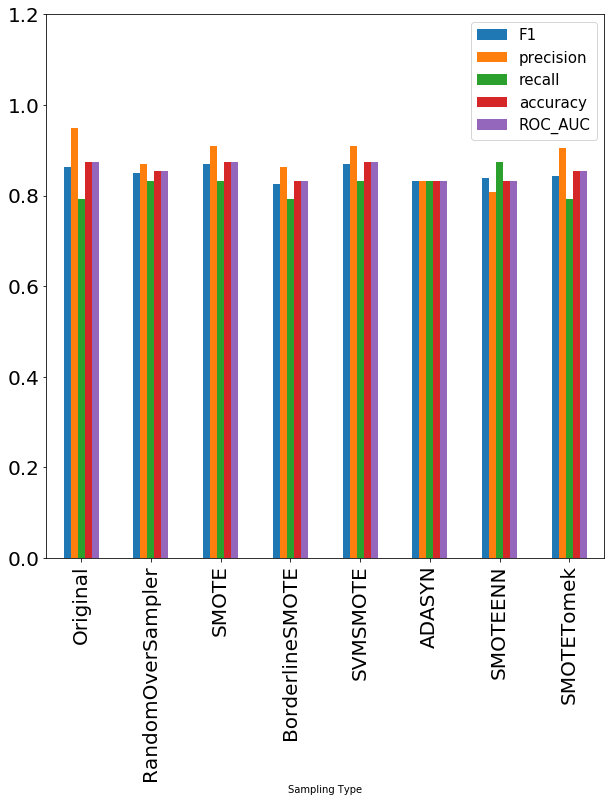

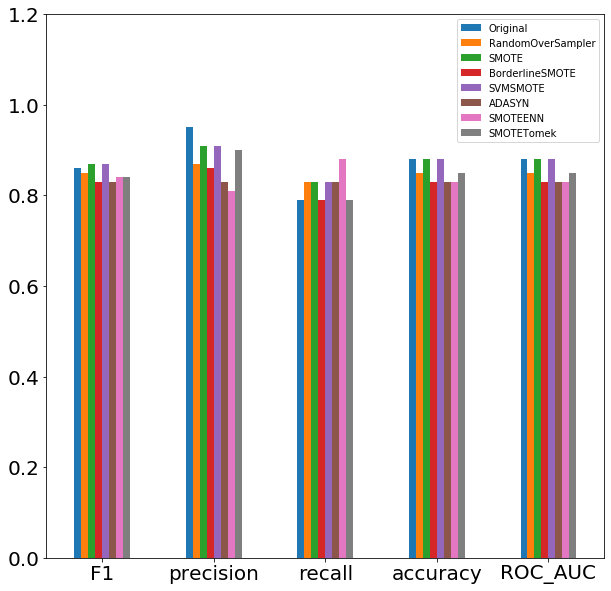

In [9]:
#print out resampling result by methods
resamp_methods_plot = sampling_results.plot(x = 'Sampling Type', ylim = (0,1.2), 
                                            kind = 'bar', rot = 90, stacked = False, 
                                            figsize = (10,10), fontsize = 20
                                           ).legend(loc=0, prop={'size': 15})
fig = resamp_methods_plot.get_figure()
fig.savefig(img_dir + "resamp_methods_plot.png")


#print out resampling result by metrics
resamp_metrics = sampling_results.transpose().iloc[:-1]
resamp_metrics.rename(columns = resamp_metrics.iloc[0],inplace=True)
resamp_metrics = resamp_metrics.iloc[1:].astype('float').round(2)
resamp_metrics_plot = resamp_metrics.plot(ylim = (0,1.2), kind = 'bar', 
                                          rot = 0 , stacked = False, 
                                          figsize = (10,10), fontsize = 20
                                         ).legend(loc=0, prop={'size': 10})
fig = resamp_metrics_plot.get_figure()
fig.savefig(img_dir + "resamp_metrics_plot.png")

Results indicate that resampling does not improve performance. Therefore, we decide **not** to apply resampling method for this dataset. 

However, depending on how imbalanced your data is and how the oversampling performs, you may want to consider resampling methods .

## Hyperparameter tuning using Grid Search (without oversampling).
This is to find the optimum hyperparameters for each model.  
Based on Grid Search [tutorial](https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html) from scikit-learn.

To perform Grid Search to obtain the best hyperparameters with oversampling, we suggest following this [tutorial](https://kiwidamien.github.io/how-to-do-cross-validation-when-upsampling-data.html).

### Setting up hyperparameters to be used in Grid Search.
We applied four different classifiers to this dataset including:
1. Gradient Boosted Decision Trees (GBDT)
2. Random Forest (RF)
3. Logistic Regression (LR)
4. Support Vector Machines (SVM)

In [10]:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import (RandomForestClassifier,GradientBoostingClassifier)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import ConstantKernel, RBF, RationalQuadratic, ExpSineSquared

#consider reducing dimensions when hyperparameter tuning if computationally too expensive
#

#GBDT----------------------------
############################################
GBDT_param_grid = {"n_estimators" : range(50,300,50),
                   "max_depth" : [None, 5, 10, 20, 40, 160, 320],
                   "min_samples_leaf" : [1, 2, 4, 8, 16, 32, 64],
                   "learning_rate": np.arange(0.01,0.1,0.01),
                   "subsample": np.arange(0.5,0.9,0.05),
                   "max_features":['auto', 5,10,20,30]
                  }

GBDT_tuned_params = {"max_features":'auto',
                  "max_depth": None,
                  "min_samples_leaf" : 2,
                  "max_depth" : 5,
                  'learning_rate': 0.08, 
                  'n_estimators': 100,
                  "subsample": 0.85
                  }

GBDT = GradientBoostingClassifier(random_state=42).set_params(**GBDT_tuned_params)


#GBDT----------------------------
############################################


#RF------------------------------
############################################
RF_param_grid = {"n_estimators" : [160, 320, 640, 1280],
                 "max_depth" : [None, 5, 10, 20, 40, 160, 320],
                 "min_samples_leaf" : [1, 2, 4, 8, 16, 32, 64],
                 "max_features":['auto', 5,10,20,30]
                } 

RF_tuned_params = {'max_depth': None,
                   'max_features': 'auto',
                   'min_samples_leaf': 1,
                   'n_estimators': 160,
                   'n_jobs': -1,
                   'random_state': 42
                  }

RF = RandomForestClassifier(random_state=42,n_jobs=-1).set_params(**RF_tuned_params)
#RF------------------------------
############################################



#LR------------------------------
############################################
LR_param_grid = {'penalty': ['l1', 'l2'], #note l1 only compatible with liblinear
                 'C':[0.001,0.01,1,5,10],
                'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}

LR_tuned_params = {'C': 1, 
                   'penalty': 'l1', 
                   'solver': 'liblinear'
                  }

LR = LogisticRegression(random_state = 42).set_params(**LR_tuned_params)

#LR------------------------------
############################################


#SVM------------------------------
############################################
SVM_param_grid = {'C': [0.1, 1, 10, 100, 1000],  
                 'gamma': [1, 0.1, 0.01, 0.001, 0.0001, 'auto', 'scale'], 
                 'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                 'probability':[True]
                 }  

SVM_tuned_params = {'C': 1000,
                    'gamma': 0.0001, 
                    'kernel': 'rbf',
                     'probability': True
                    }
SVM = SVC(random_state=42).set_params(**SVM_tuned_params)

#SVM------------------------------
############################################


### Grid Search cross validation search
Make sure the `train/test` data splitting use the **same** random_state/seed for the **Grid Search**, **cross validation** and **test set** to avoid data leakage.

In [11]:
from sklearn.metrics import (recall_score,accuracy_score,confusion_matrix, f1_score, precision_score, 
                             auc,roc_auc_score,roc_curve, precision_recall_curve,classification_report)
from sklearn.model_selection import GridSearchCV,train_test_split

#features/target splitting
X = df_scaled.iloc[:,9:]
y = df_scaled['cutoff_2'].apply(lambda x: 0 if x == 'inactive' else 1)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.20, random_state = 888)

model = LR
param_grid = LR_param_grid

#to test other metrics, uncomment below or add your own metrics
scores = [
        'accuracy',
#        'precision',
#          'roc_auc'
         ]

for score in scores:
    print("# Tuning the hyper-parameters for {}".format(score))
    gs = GridSearchCV(model, param_grid = param_grid, cv = 10, scoring='%s' % score,n_jobs=-1)
    gs.fit(X_train.values, y_train.values.ravel())

    print("Best parameters set found:\n",gs.best_params_)
    print("Best score:\n", gs.best_score_) 

#detailed scores for grid_search
#pd.DataFrame(gs.cv_results_)

# Tuning the hyper-parameters for accuracy
Best parameters set found:
 {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
Best score:
 0.8336842105263157


## K-fold cross validation and testing for models with tuned parameters

### Setting up K-fold validation helper fuction.

In [12]:
from sklearn.model_selection import KFold
from sklearn.metrics import (recall_score,accuracy_score,confusion_matrix, f1_score, precision_score, 
                             auc,roc_auc_score,roc_curve, precision_recall_curve,classification_report)

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC


#K-fold validation function will take six arguments: 
#1. model, 2. train set, 3.test set, 4.# of fold, 5.shuffle boolean, 6.random_state.
def kf_cv(clf, X, y, folds = 10, shuf = True, random_state=42):
    cv = KFold(n_splits=folds, random_state=42, shuffle=shuf)
    f1,prec,recall,acc,ROC_AUC,conf = ([],[],[],[],[],[])
    metric_cols=['F1','precision','recall','accuracy','ROC_AUC','confusion_matrix']
    print('Classifier ##{0}## will be used with {1} folds, and shuffle mode is {2}'.format(clf.__class__.__name__,
                                                                                       folds,
                                                                                       'on' if shuf else 'off')
         )
    
    for train_index, test_index in cv.split(X):
        #turn on the below code will print train_index/test_index and may help understand the details and debug.
        #print("Train Index: ", train_index, "\n")
        #print("Test Index: ", test_index)
        
        X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]
        #if sampling method is used, use this to avoid warnings: clf.fit(X_train.values, y_train.values.ravel())
        clf.fit(X_train, y_train.ravel())
        
        pred_test = clf.predict(X_test)
        pred_test_probs = clf.predict_proba(X_test)
        fpr, tpr, thresholds = roc_curve(y_test,pred_test)
        
        f1.append(f1_score(y_test,pred_test))
        prec.append(precision_score(y_test,pred_test))
        recall.append(recall_score(y_test,pred_test))
        acc.append(accuracy_score(y_test,pred_test))
        ROC_AUC.append(roc_auc_score(y_test, pred_test_probs[:,1]))       
        conf.append(confusion_matrix(y_test,pred_test))
        
    #return a dataframe consisting five metrics and confusion matrix.
    return pd.DataFrame(zip(f1,prec,recall,acc,ROC_AUC,conf), columns = metric_cols)


### Run 10-fold cross validation (CV)
Train/test spliting is set to 80/20.  
Make sure the `train/test` data splitting use the **same** random_state/seed for the **Grid Search**, **cross validation** and **test set** to avoid data leakage.

In [13]:
#setting up train/test set (80/20), make sure this is the same split as the GS.

#features/target splitting
X = df_scaled.iloc[:,9:]
y = df_scaled['cutoff_2'].apply(lambda x: 0 if x == 'inactive' else 1)

#make sure datasets are converted from pandas DataFrame into numpy ndarray avoid errors in machine learning.
if type(X) is not np.ndarray:
    X, y = X.to_numpy(),y.to_numpy()
else:
    print('X,y already converted to ndarray')
    
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.20, random_state = 888) #same random_state as previous GS

#setting up models using tuned hyperparameters from Grid Search.
GBDT = GradientBoostingClassifier(random_state=42).set_params(**GBDT_tuned_params)
RF = RandomForestClassifier(random_state=42).set_params(**RF_tuned_params)
LR = LogisticRegression(random_state=42).set_params(**LR_tuned_params)
SVM = SVC(random_state=42).set_params(**SVM_tuned_params)

#create dictionary to store k-fold CV results
cv_score_dict = {}
#create a dataframe to store the mean and standard error of the mean (SEM) from k-fold CV
cv_score_mean = pd.DataFrame()
cv_score_sem = pd.DataFrame()

#run k-fold CV
for model_name in ['RF','GBDT','LR','SVM']:
    clf = eval(model_name)
    cv_score_dict[model_name] = kf_cv(clf,X_train,y_train,10,True)
    cv_score_mean[model_name] = cv_score_dict[model_name].mean()[:-1]
    cv_score_sem[model_name] = cv_score_dict[model_name].sem()
    
cv_score_mean = cv_score_mean.transpose().astype(float).round(2)
cv_score_sem = cv_score_sem.transpose().round(2)

print('\n\ndetail results in dictionary "cv_score_dict" using model_name as key')
print('Performace summary in df "cv_score_mean" and "cv_score_sem"')

# check mean performance of each model.
cv_score_mean

Classifier ##RandomForestClassifier## will be used with 10 folds, and shuffle mode is on
Classifier ##GradientBoostingClassifier## will be used with 10 folds, and shuffle mode is on
Classifier ##LogisticRegression## will be used with 10 folds, and shuffle mode is on
Classifier ##SVC## will be used with 10 folds, and shuffle mode is on


detail results in dictionary "cv_score_dict" using model_name as key
Performace summary in df "cv_score_mean" and "cv_score_sem"


,F1,precision,recall,accuracy,ROC_AUC
RF,0.70,0.70,0.74,0.83,0.90
GBDT,0.63,0.69,0.66,0.79,0.88
LR,0.69,0.73,0.71,0.83,0.90
SVM,0.69,0.73,0.71,0.82,0.90


In [14]:
# for example, to see detailed result of RF:
cv_score_dict['RF']

,F1,precision,recall,accuracy,ROC_AUC,confusion_matrix
0,0.533333,0.800000,0.400000,0.650000,0.900000,"[[9, 1], [6, 4]]"
1,0.705882,0.857143,0.600000,0.750000,0.860000,"[[9, 1], [4, 6]]"
2,0.500000,0.500000,0.500000,0.894737,0.941176,"[[16, 1], [1, 1]]"
3,0.857143,0.750000,1.000000,0.947368,0.979167,"[[15, 1], [0, 3]]"
4,0.600000,0.428571,1.000000,0.789474,0.968750,"[[12, 4], [0, 3]]"
5,0.923077,0.857143,1.000000,0.947368,0.961538,"[[12, 1], [0, 6]]"
6,0.769231,0.833333,0.714286,0.842105,0.892857,"[[11, 1], [2, 5]]"
7,0.500000,0.500000,0.500000,0.789474,0.825000,"[[13, 2], [2, 2]]"
8,0.823529,0.777778,0.875000,0.842105,0.846591,"[[9, 2], [1, 7]]"
9,0.769231,0.714286,0.833333,0.842105,0.858974,"[[11, 2], [1, 5]]"


### Plot k-fold CV

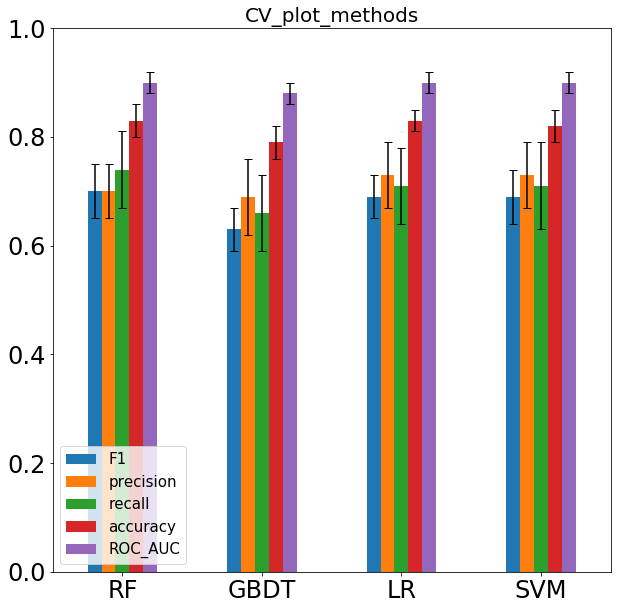

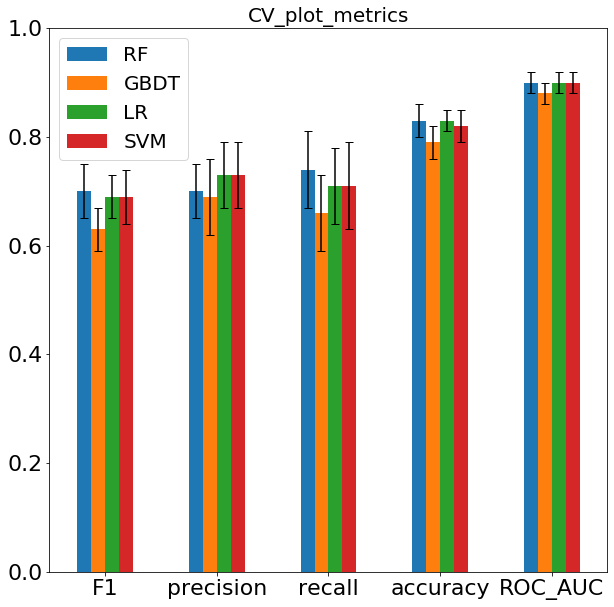

In [15]:
#plot k-fold CV by methods
CV_plot_methods = cv_score_mean.plot(ylim = (0,1), kind = 'bar', 
                                    rot = 0 , stacked = False,
                                    yerr = cv_score_sem, capsize=4,
                                    figsize = (10,10), fontsize = 24)
plt.legend(loc=3, prop={'size': 15})
plt.title('CV_plot_methods',fontsize = 20)
plt.savefig(img_dir + "CV_plot_methods.png")


#plot k-fold CV by metrics
CV_plot_metrics = cv_score_mean.transpose().plot(kind = 'bar', ylim = (0,1),
                                                rot = 0, stacked = False,
                                                yerr = cv_score_sem.transpose(), capsize=4,
                                                figsize = (10,10), fontsize = 22)
plt.legend(loc=2, prop={'size': 20})
plt.title('CV_plot_metrics',fontsize = 20)
plt.savefig(img_dir + "CV_plot_metrics.png")

### Run test set after 10-fold cross-validation
Train/test spliting is set to 80/20.  
Make sure the `train/test` data splitting use the **same** random_state/seed for the **Grid Search**, **cross validation** and **test set** to avoid data leakage.

In [16]:
#create a dataframe to store test set performance
test_set_result = pd.DataFrame()
f1,prec,recall,acc,ROC_AUC,conf = ([],[],[],[],[],[])

#evaluate the performance of the different classifiers
for model_name in ['RF','GBDT','LR','SVM']:
    clf = eval(model_name)

    clf.fit(X_train, y_train.ravel())

    pred_test = clf.predict(X_test)
    pred_test_probs = clf.predict_proba(X_test)
    fpr, tpr, thresholds = roc_curve(y_test,pred_test)

    f1.append(f1_score(y_test,pred_test))
    prec.append(precision_score(y_test,pred_test))
    recall.append(recall_score(y_test,pred_test))
    acc.append(accuracy_score(y_test,pred_test))
    ROC_AUC.append(roc_auc_score(y_test, pred_test_probs[:,1]))       
    conf.append(confusion_matrix(y_test,pred_test))
    
test_set_scores = zip(f1,prec,recall,acc,ROC_AUC,conf)   

test_set_result = pd.DataFrame(test_set_scores, 
                               columns=['F1','precision','recall',
                                        'accuracy','ROC_AUC','confusion_matrix'], 
                               index = ['RF','GBDT','LR','SVM'])
test_set_result.round(2)

,F1,precision,recall,accuracy,ROC_AUC,confusion_matrix
RF,0.86,0.95,0.79,0.88,0.89,"[[23, 1], [5, 19]]"
GBDT,0.74,1.00,0.58,0.79,0.94,"[[24, 0], [10, 14]]"
LR,0.84,0.95,0.75,0.85,0.95,"[[23, 1], [6, 18]]"
SVM,0.81,0.94,0.71,0.83,0.94,"[[23, 1], [7, 17]]"


### Plot test set results

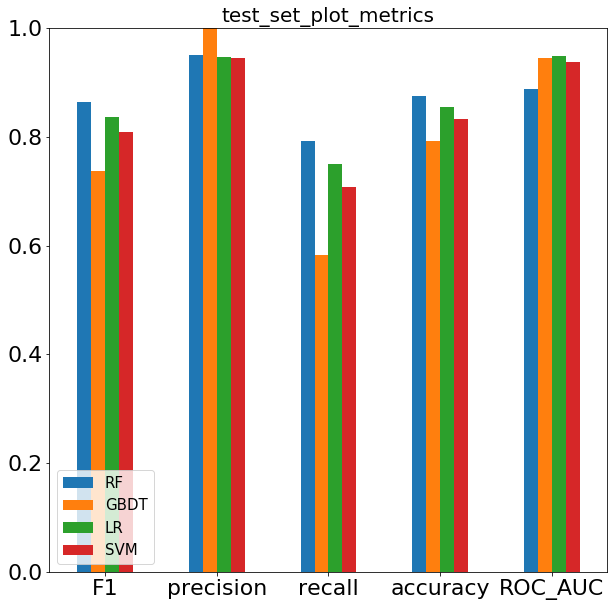

In [17]:
# adjust result
test_set_plot_metrics = test_set_result.iloc[:,:-1].transpose().plot(kind = 'bar', ylim = (0,1),
                                                rot = 0, stacked = False, legend=False,
                                                figsize = (10,10), fontsize = 22)

plt.legend(loc=3, prop={'size': 15})
plt.title('test_set_plot_metrics',fontsize = 20)
plt.savefig(img_dir + "test_set_plot_metrics.png")

## Leaving protein out test (LPOT)
We have 12 proteins in our dataset. Here we are going to test the model performance when 2,3,4,6 proteins are randomly or phylogenetically left out.

### Reorder protein phylogenetically.
This enable us to see how leaving out proteins in phylogenetic order performs.

<img src="../../../manuscript/figures/tree-01.png" width="400">

In [18]:
#fetch unique proteins
df_scaled['protein'].unique()

array(['1a1', '1a17', '1a2', '1a27', '1a8', '1b15', '1b16', '2a6', '3a2',
       '3wuy', 'pmi26', 'pmi28'], dtype=object)

In [19]:
#reorder phylogenetically (convert labels from 1d array to list so to avoid zipping problem in the following function)
nitrilases = ['1a1', '1a2', '1a8', 'pmi28', '1a17', '1a27', 'pmi26', '3wuy', '1b16',
       '1b15', '2a6', '3a2']

### Build helper function for LPOT
Starting by building a helper function that can `randomly` or `phylogenetically` assign a number of proteins as a test set and use the remaining proteins as the training set.

This LPOT function takes `4 arguments`:
    1. The classifier
    2. The number of proteins to leave out as test set
    3. The `shuffle` boolean (randomly or phylogenetically)
    4. The random_state/seed
    
It returns a dataframe with metrics as columns and test set proteins as indices.
    1. metrics such as preset 'f1','precision','recall','accuracy','auc_roc','confusion_matrix' can be easily swapped.
    2. indices are printed out in the following format : 'protein1_protein2_protein3'.

In [20]:
#unique proteins in the dataset
num_of_protein = df_scaled['protein'].unique().shape[0]

def LPOT(clf, num_leave_out, shuffle = False, seed = 888): 
    #the num_of_protein needs to be defined as num_of_protein = protein_labels.shape[0]
    if num_of_protein%num_leave_out != 0:
        raise Exception('The num_leave_out is not the divisor of total number of protein!')
    
    #metrics to be recorded
    test_set,f1,prec,recall,acc,ROC_AUC,conf = ([],[],[],[],[],[],[])
    metric_cols=['F1','precision','recall','accuracy','ROC_AUC','confusion_matrix']
    
    #your own list of unique proteins phylogenetically ordered
    protein_labels = nitrilases 
    
    #shuffle the protein labels if `shuffle` is True
    if shuffle:
        np.random.RandomState(seed = seed).shuffle(protein_labels)
    
    #determine the fold
    fold = int(num_of_protein/num_leave_out)
    
    print('\n Shuffle is {},\n Starting prediction'.format( "On" if shuffle else "Off"))
    
    for i in range(fold):
        
        test_protein = protein_labels[num_leave_out * i :num_leave_out * (i+1)]
        test_index = df_scaled[df_scaled['protein'].isin(test_protein)].index
        train_index = df_scaled[~df_scaled['protein'].isin(test_protein)].index
        
        print('Model: {}, test set {}'.format(clf.__class__.__name__,test_protein))
        
        X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]
        
        clf.fit(X_train, y_train.ravel())
        
        pred_test = clf.predict(X_test)
        pred_test_probs = clf.predict_proba(X_test)
        fpr, tpr, thresholds = roc_curve(y_test,pred_test)
        
        
        test_set.append('_'.join(test_protein))
        f1.append(f1_score(y_test,pred_test))
        prec.append(precision_score(y_test,pred_test))
        recall.append(recall_score(y_test,pred_test))
        acc.append(accuracy_score(y_test,pred_test))
        ROC_AUC.append(roc_auc_score(y_test, pred_test_probs[:,1]))       
        conf.append(confusion_matrix(y_test,pred_test))

    return pd.DataFrame(zip(f1,prec,recall,acc,ROC_AUC,conf),index = test_set, columns = metric_cols)

## Run leave one out test (LOOT)
Note: This is not a leave one out validation (LOOV).  
In our leave one out test (LOOT), each protein was treated as test set while the other 11 were used to train the model.

In [21]:
loot_score_mean = pd.DataFrame()
loot_score_sem = pd.DataFrame()
loot_score_dict = {}

#run LOOT using the helper function.
for model_name in ['RF','GBDT','LR','SVM']:
    clf = eval(model_name)
    #set the number of proteins to one.
    loot_model_score = LPOT(clf,1, shuffle = False)
    
    loot_score_dict[model_name] = loot_model_score
    loot_score_mean[model_name.upper()] = loot_model_score.mean()[:-1].astype(float).round(2)
    loot_score_sem[model_name.upper()] = loot_model_score.sem().round(2)


 Shuffle is Off,
 Starting prediction
Model: RandomForestClassifier, test set ['1a1']
Model: RandomForestClassifier, test set ['1a2']
Model: RandomForestClassifier, test set ['1a8']
Model: RandomForestClassifier, test set ['pmi28']
Model: RandomForestClassifier, test set ['1a17']
Model: RandomForestClassifier, test set ['1a27']
Model: RandomForestClassifier, test set ['pmi26']
Model: RandomForestClassifier, test set ['3wuy']
Model: RandomForestClassifier, test set ['1b16']
Model: RandomForestClassifier, test set ['1b15']
Model: RandomForestClassifier, test set ['2a6']
Model: RandomForestClassifier, test set ['3a2']

 Shuffle is Off,
 Starting prediction
Model: GradientBoostingClassifier, test set ['1a1']
Model: GradientBoostingClassifier, test set ['1a2']
Model: GradientBoostingClassifier, test set ['1a8']
Model: GradientBoostingClassifier, test set ['pmi28']
Model: GradientBoostingClassifier, test set ['1a17']
Model: GradientBoostingClassifier, test set ['1a27']
Model: GradientBoosti

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1268: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1268: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Model: SVC, test set ['pmi26']
Model: SVC, test set ['3wuy']
Model: SVC, test set ['1b16']
Model: SVC, test set ['1b15']
Model: SVC, test set ['2a6']
Model: SVC, test set ['3a2']


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1268: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [22]:
#inspect LOOT results for each classifier
loot_score_dict['SVM'].round(2)

,F1,precision,recall,accuracy,ROC_AUC,confusion_matrix
1a1,0.75,0.60,1.00,0.80,0.93,"[[10, 4], [0, 6]]"
1a2,0.33,1.00,0.20,0.80,0.95,"[[15, 0], [4, 1]]"
1a8,0.40,0.25,1.00,0.70,0.78,"[[12, 6], [0, 2]]"
pmi28,0.71,1.00,0.55,0.75,0.95,"[[9, 0], [5, 6]]"
1a17,0.88,1.00,0.78,0.90,1.00,"[[11, 0], [2, 7]]"
1a27,0.78,1.00,0.64,0.80,0.97,"[[9, 0], [4, 7]]"
pmi26,0.77,0.71,0.83,0.85,0.90,"[[12, 2], [1, 5]]"
3wuy,0.93,1.00,0.88,0.95,1.00,"[[12, 0], [1, 7]]"
1b16,0.92,0.86,1.00,0.95,0.94,"[[13, 1], [0, 6]]"
1b15,0.44,0.29,1.00,0.75,0.86,"[[13, 5], [0, 2]]"


In [23]:
#print out LOOT mean and sem scores
print("loot_score_mean\n",loot_score_mean)
print("\nloot_score_std\n",loot_score_sem)


loot_score_mean
              RF  GBDT    LR   SVM
F1         0.74  0.63  0.62  0.63
precision  0.78  0.76  0.62  0.70
recall     0.82  0.71  0.70  0.71
accuracy   0.83  0.77  0.81  0.80
ROC_AUC    0.90  0.88  0.92  0.92

loot_score_std
              RF  GBDT    LR   SVM
F1         0.05  0.06  0.09  0.08
precision  0.08  0.08  0.11  0.10
recall     0.05  0.09  0.10  0.09
accuracy   0.03  0.03  0.03  0.03
ROC_AUC    0.02  0.03  0.02  0.02


### Plot LOOT results

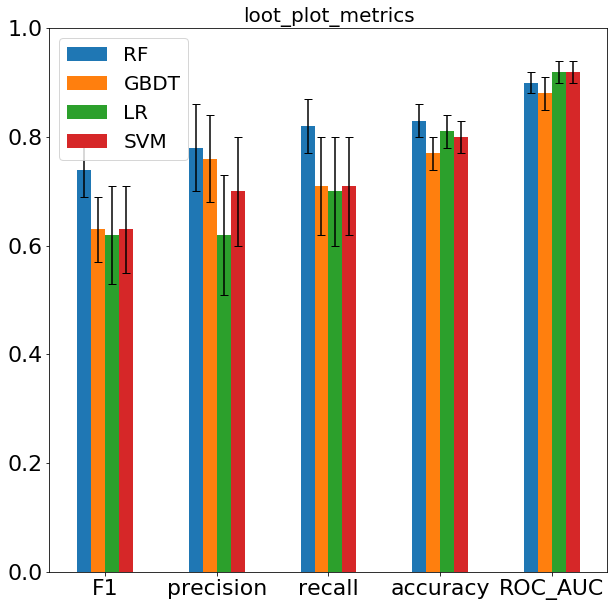

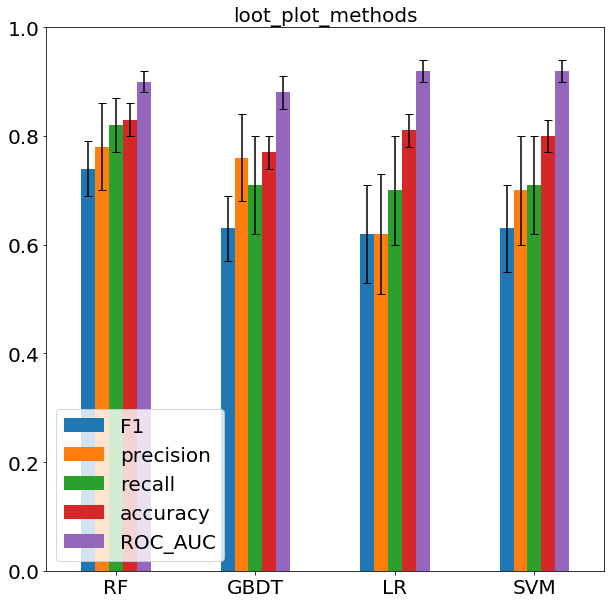

In [24]:
import matplotlib.pyplot as plt
#plot metrics
loot_plot_metrics = loot_score_mean.plot(ylim = (0,1), kind = 'bar', 
                                         rot = 0 , stacked = False,legend = False,
                                         yerr = loot_score_sem, capsize=4,
                                         figsize = (10,10), fontsize = 22
                                        )
plt.legend(loc=2, prop={'size': 20})
plt.title('loot_plot_metrics',fontsize = 20)
plt.savefig(img_dir + "loot_plot_metrics.png")


#plot methods
loot_plot_methods = loot_score_mean.transpose().plot(kind = 'bar', ylim = (0,1),
                                                     rot = 0, stacked = False, 
                                                     yerr = loot_score_sem.transpose(), capsize=4,
                                                     figsize = (10,10), fontsize = 20
                                                     )
plt.legend(loc=3, prop={'size': 20})
plt.title('loot_plot_methods',fontsize = 20)
plt.savefig(img_dir + "loot_plot_methods.png")

### Make prediction table
e.g. random forest

In [25]:
protein_labels_new = df_scaled['protein'].unique().tolist()

#create prediction table
LOOT_pred_table = pd.DataFrame(index = df_scaled['nitriles'][0:20])
del LOOT_pred_table.index.name

#e.g. random forest
clf = rf

#loop through each protein.
for test_protein in protein_labels_new:
        test_index = df_scaled[df_scaled['protein']==test_protein].index
        train_index = df_scaled[df_scaled['protein']!=test_protein].index
        #print ('\n testing:',test_protein, test_index) #print index for each run
        X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]
        clf.fit(X_train, y_train.ravel())
        pred_test = clf.predict(X_test)
        LOOT_pred_table[test_protein] = (pred_test == y_test)
        
# making prediction table
LOOT_pred_table_trans = LOOT_pred_table.transpose()
LOOT_pred_table_trans.to_csv(img_dir + 'LOOT_table.csv')


####uncomment the below codes to plot it 

# sns.set(font_scale=1.5)
# f, ax = plt.subplots(figsize=(11, 10))

# ax = sns.heatmap(LOOT_pred_table_trans, cbar=False, linewidths=1)
# ax.set_yticklabels(ax.get_yticklabels(), rotation = 0, fontsize = 20)
# ax.set_xticklabels(ax.get_xticklabels(), rotation = 90, fontsize = 15)
# ax.set_ylim(12,0)

# plt.title('LOOT_pred_table',fontsize = 20)
# plt.tight_layout()
# plt.savefig("LOOT_pred_table.png")

### Run leave two out phylogenetically and randomly
For our dataset **2 out of 12** proteins will be used as test set.  
Data will be separated into **6 folds**.

#### Leaving two out phylogenetically


 Shuffle is Off,
 Starting prediction
Model: RandomForestClassifier, test set ['1a1', '1a2']
Model: RandomForestClassifier, test set ['1a8', 'pmi28']
Model: RandomForestClassifier, test set ['1a17', '1a27']
Model: RandomForestClassifier, test set ['pmi26', '3wuy']
Model: RandomForestClassifier, test set ['1b16', '1b15']
Model: RandomForestClassifier, test set ['2a6', '3a2']

 Shuffle is Off,
 Starting prediction
Model: GradientBoostingClassifier, test set ['1a1', '1a2']
Model: GradientBoostingClassifier, test set ['1a8', 'pmi28']
Model: GradientBoostingClassifier, test set ['1a17', '1a27']
Model: GradientBoostingClassifier, test set ['pmi26', '3wuy']
Model: GradientBoostingClassifier, test set ['1b16', '1b15']
Model: GradientBoostingClassifier, test set ['2a6', '3a2']

 Shuffle is Off,
 Starting prediction
Model: LogisticRegression, test set ['1a1', '1a2']
Model: LogisticRegression, test set ['1a8', 'pmi28']
Model: LogisticRegression, test set ['1a17', '1a27']
Model: LogisticRegressio

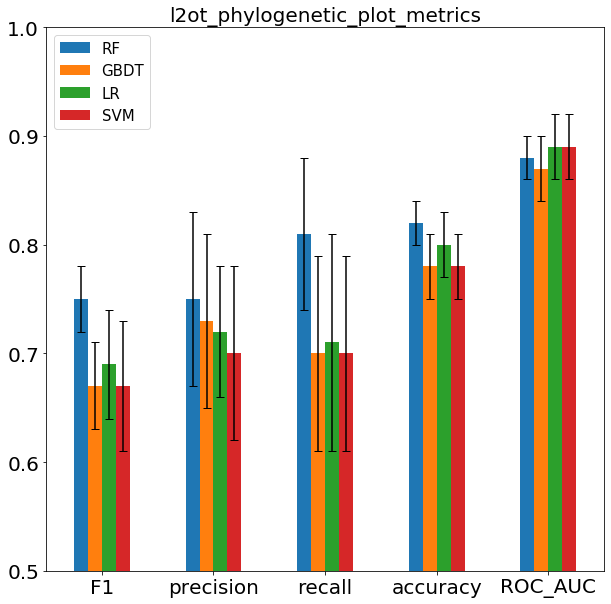

In [26]:
l2ot_phylogenetic_score_mean = pd.DataFrame()
l2ot_phylogenetic_score_sem = pd.DataFrame()
l2ot_phylogenetic_score_dict = {}

#run l2ot using the helper function. Shuffle is turned off
for model_name in ['RF','GBDT','LR','SVM']:
    clf = eval(model_name)
    #set the number of proteins.
    l2ot_phylogenetic_model_score = LPOT(clf,2, shuffle = False)
    
    l2ot_phylogenetic_score_dict[model_name] = l2ot_phylogenetic_model_score
    l2ot_phylogenetic_score_mean[model_name] = l2ot_phylogenetic_model_score.mean()[:-1].astype(float).round(2)
    l2ot_phylogenetic_score_sem[model_name] = l2ot_phylogenetic_model_score.sem().round(2)
    
#print out l2ot-phylogeneticed performance by mean and sem scores
print("\n l2ot-phylogeneticed_score_mean\n",l2ot_phylogenetic_score_mean)
print("\n l2ot-phylogeneticed_sem\n",l2ot_phylogenetic_score_sem)

#plot result by metrics
l2ot_phylogenetic_plot_metrics = l2ot_phylogenetic_score_mean.plot(kind = 'bar', ylim = (0.5,1),
                                                     rot = 0, stacked = False,
                                                     yerr = l2ot_phylogenetic_score_sem, capsize=4,
                                                     figsize = (10,10), fontsize = 20)
plt.legend(loc=2, prop={'size': 15})
plt.title('l2ot_phylogenetic_plot_metrics',fontsize = 20)
plt.savefig(img_dir + "l2ot_phylogenetic_plot_metrics.png")

#### Leaving two out randomly


 Shuffle is On,
 Starting prediction
Model: RandomForestClassifier, test set ['1a8', '1b15']
Model: RandomForestClassifier, test set ['1a27', '1a1']
Model: RandomForestClassifier, test set ['1b16', '1a17']
Model: RandomForestClassifier, test set ['1a2', '3a2']
Model: RandomForestClassifier, test set ['3wuy', 'pmi28']
Model: RandomForestClassifier, test set ['pmi26', '2a6']

 Shuffle is On,
 Starting prediction
Model: GradientBoostingClassifier, test set ['1a27', 'pmi28']
Model: GradientBoostingClassifier, test set ['1a17', '1a8']
Model: GradientBoostingClassifier, test set ['3wuy', '1b16']
Model: GradientBoostingClassifier, test set ['1b15', '2a6']
Model: GradientBoostingClassifier, test set ['3a2', '1a1']
Model: GradientBoostingClassifier, test set ['1a2', 'pmi26']

 Shuffle is On,
 Starting prediction
Model: LogisticRegression, test set ['1a17', '1a1']
Model: LogisticRegression, test set ['1b16', '1a27']
Model: LogisticRegression, test set ['3a2', '3wuy']
Model: LogisticRegression, 

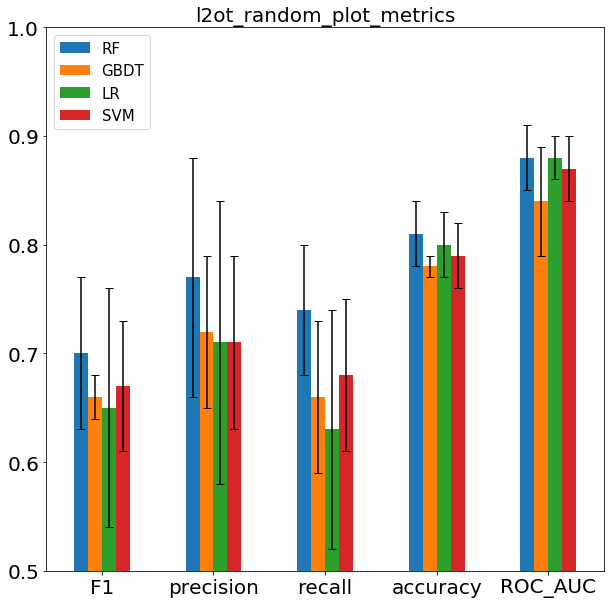

In [27]:
l2ot_random_score_mean = pd.DataFrame()
l2ot_random_score_sem = pd.DataFrame()
l2ot_random_score_dict = {}

for model_name in ['RF','GBDT','LR','SVM']:
    clf = eval(model_name)
    #set the number of proteins.
    l2ot_random_model_score = LPOT(clf,2,shuffle = True)
    
    l2ot_random_score_dict[model_name] = l2ot_random_model_score
    l2ot_random_score_mean[model_name] = l2ot_random_model_score.mean()[:-1].astype(float).round(2)
    l2ot_random_score_sem[model_name] = l2ot_random_model_score.sem().round(2)
    
#print out l2ot-randomed performance by mean and sem scores
print("\n l2ot-random_score_mean\n",l2ot_random_score_mean)
print("\n l2ot-random_sem\n",l2ot_random_score_sem)

#plot result by metrics
l2ot_random_plot_metrics = l2ot_random_score_mean.plot(kind = 'bar', ylim = (0.5,1),
                                                       rot = 0, stacked = False,
                                                       yerr = l2ot_random_score_sem, capsize=4,
                                                       figsize = (10,10), fontsize = 20)
plt.legend(loc=2, prop={'size': 15})
plt.title('l2ot_random_plot_metrics',fontsize = 20)
plt.savefig(img_dir + "l2ot_random_plot_metrics.png")

In [28]:
#inspect the performance of each classifier (comment one out)
l2ot_phylogenetic_score_dict['RF']
l2ot_random_score_dict['RF']

,F1,precision,recall,accuracy,ROC_AUC,confusion_matrix
1a8_1b15,0.380952,0.235294,1.000000,0.675,0.819444,"[[23, 13], [0, 4]]"
1a27_1a1,0.800000,0.923077,0.705882,0.850,0.892583,"[[22, 1], [5, 12]]"
1b16_1a17,0.814815,0.916667,0.733333,0.875,0.957333,"[[24, 1], [4, 11]]"
1a2_3a2,0.750000,0.818182,0.692308,0.850,0.910256,"[[25, 2], [4, 9]]"
3wuy_pmi28,0.733333,1.000000,0.578947,0.800,0.934837,"[[21, 0], [8, 11]]"
pmi26_2a6,0.733333,0.733333,0.733333,0.800,0.794667,"[[21, 4], [4, 11]]"


### Run leave three out phylogenetically and randomly
**3 out of 12** proteins will be used as test set.  
Data will be separated into **4** folds.

#### Leaving three out phylogenetically 


 Shuffle is Off,
 Starting prediction
Model: RandomForestClassifier, test set ['1b16', '1a8', '3wuy']
Model: RandomForestClassifier, test set ['1a17', '2a6', '3a2']
Model: RandomForestClassifier, test set ['1a1', '1a2', 'pmi26']
Model: RandomForestClassifier, test set ['1a27', 'pmi28', '1b15']

 Shuffle is Off,
 Starting prediction
Model: GradientBoostingClassifier, test set ['1b16', '1a8', '3wuy']
Model: GradientBoostingClassifier, test set ['1a17', '2a6', '3a2']
Model: GradientBoostingClassifier, test set ['1a1', '1a2', 'pmi26']
Model: GradientBoostingClassifier, test set ['1a27', 'pmi28', '1b15']

 Shuffle is Off,
 Starting prediction
Model: LogisticRegression, test set ['1b16', '1a8', '3wuy']
Model: LogisticRegression, test set ['1a17', '2a6', '3a2']
Model: LogisticRegression, test set ['1a1', '1a2', 'pmi26']
Model: LogisticRegression, test set ['1a27', 'pmi28', '1b15']

 Shuffle is Off,
 Starting prediction
Model: SVC, test set ['1b16', '1a8', '3wuy']
Model: SVC, test set ['1a17'

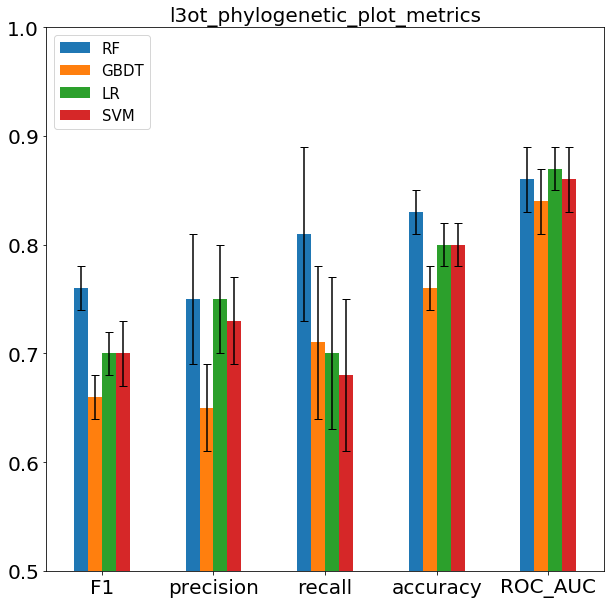

In [29]:
l3ot_phylogenetic_score_mean = pd.DataFrame()
l3ot_phylogenetic_score_sem = pd.DataFrame()
l3ot_phylogenetic_score_dict = {}

#run l3ot using the helper function. Shuffle is turned off
for model_name in ['RF','GBDT','LR','SVM']:
    clf = eval(model_name)
    #set the number of proteins.
    l3ot_phylogenetic_model_score = LPOT(clf,3,shuffle = False)
    
    l3ot_phylogenetic_score_dict[model_name] = l3ot_phylogenetic_model_score
    l3ot_phylogenetic_score_mean[model_name] = l3ot_phylogenetic_model_score.mean()[:-1].astype(float).round(2)
    l3ot_phylogenetic_score_sem[model_name] = l3ot_phylogenetic_model_score.sem().round(2)
    
#print out l3ot-phylogeneticed performance by mean and sem scores
print("\n l3ot-phylogeneticed_score_mean\n",l3ot_phylogenetic_score_mean)
print("\n l3ot-phylogeneticed_sem\n",l3ot_phylogenetic_score_sem)

#plot result by metrics
l3ot_phylogenetic_plot_metrics = l3ot_phylogenetic_score_mean.plot(kind = 'bar', ylim = (0.5,1),
                                                rot = 0, stacked = False,
                                                yerr = l3ot_phylogenetic_score_sem, capsize=4,
                                                figsize = (10,10), fontsize = 20)
plt.legend(loc=2, prop={'size': 15})
plt.title('l3ot_phylogenetic_plot_metrics',fontsize = 20)
plt.savefig(img_dir + "l3ot_phylogenetic_plot_metrics.png")

#### Leaving three out randomly


 Shuffle is On,
 Starting prediction
Model: RandomForestClassifier, test set ['3wuy', '1a27', '3a2']
Model: RandomForestClassifier, test set ['1b16', 'pmi26', '2a6']
Model: RandomForestClassifier, test set ['1a8', '1b15', '1a2']
Model: RandomForestClassifier, test set ['1a17', '1a1', 'pmi28']

 Shuffle is On,
 Starting prediction
Model: GradientBoostingClassifier, test set ['3a2', '1a17', '2a6']
Model: GradientBoostingClassifier, test set ['3wuy', '1a2', 'pmi26']
Model: GradientBoostingClassifier, test set ['1a27', 'pmi28', '1b15']
Model: GradientBoostingClassifier, test set ['1b16', '1a8', '1a1']

 Shuffle is On,
 Starting prediction
Model: LogisticRegression, test set ['2a6', '1b16', 'pmi26']
Model: LogisticRegression, test set ['3a2', '1b15', '1a2']
Model: LogisticRegression, test set ['1a17', '1a1', 'pmi28']
Model: LogisticRegression, test set ['3wuy', '1a27', '1a8']

 Shuffle is On,
 Starting prediction
Model: SVC, test set ['pmi26', '3wuy', '1a2']
Model: SVC, test set ['2a6', 'p

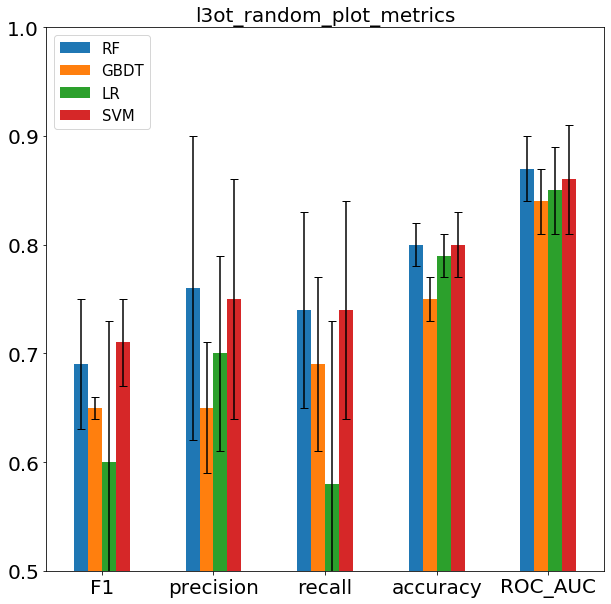

In [30]:
l3ot_random_score_mean = pd.DataFrame()
l3ot_random_score_sem = pd.DataFrame()
l3ot_random_score_dict = {}

for model_name in ['RF','GBDT','LR','SVM']:
    clf = eval(model_name)
    #set the number of proteins.
    l3ot_random_model_score = LPOT(clf,3,shuffle = True)
    
    l3ot_random_score_dict[model_name] = l3ot_random_model_score
    l3ot_random_score_mean[model_name] = l3ot_random_model_score.mean()[:-1].astype(float).round(2)
    l3ot_random_score_sem[model_name] = l3ot_random_model_score.sem().round(2)
    
#print out l3ot-randomed performance by mean and sem scores
print("\n l3ot-random_score_mean\n",l3ot_random_score_mean)
print("\n l3ot-random_sem\n",l3ot_random_score_sem)

#plot result by metrics
l3ot_random_plot_metrics = l3ot_random_score_mean.plot(kind = 'bar', ylim = (0.5,1),
                                                rot = 0, stacked = False,
                                                yerr = l3ot_random_score_sem, capsize=4,
                                                figsize = (10,10), fontsize = 20)
plt.legend(loc=2, prop={'size': 15})
plt.title('l3ot_random_plot_metrics',fontsize = 20)
plt.savefig(img_dir + "l3ot_random_plot_metrics.png")

In [31]:
#inspect the performance of each model
l3ot_phylogenetic_score_dict['RF']
l3ot_random_score_dict['RF']

,F1,precision,recall,accuracy,ROC_AUC,confusion_matrix
3wuy_1a27_3a2,0.772727,1.000000,0.629630,0.833333,0.913019,"[[33, 0], [10, 17]]"
1b16_pmi26_2a6,0.761905,0.761905,0.761905,0.833333,0.826007,"[[34, 5], [5, 16]]"
1a8_1b15_1a2,0.529412,0.360000,1.000000,0.733333,0.818083,"[[35, 16], [0, 9]]"
1a17_1a1_pmi28,0.714286,0.937500,0.576923,0.800000,0.909502,"[[33, 1], [11, 15]]"


### Run leave four out phylogenetically and randomly
**4 out of 12** proteins will be used as test set.
Data will be separated into **3** folds.

#### Leaving four out phylogenetically


 Shuffle is Off,
 Starting prediction
Model: RandomForestClassifier, test set ['pmi26', '3wuy', '1a2', '2a6']
Model: RandomForestClassifier, test set ['pmi28', '1b15', '1b16', '1a8']
Model: RandomForestClassifier, test set ['1a1', '3a2', '1a17', '1a27']

 Shuffle is Off,
 Starting prediction
Model: GradientBoostingClassifier, test set ['pmi26', '3wuy', '1a2', '2a6']
Model: GradientBoostingClassifier, test set ['pmi28', '1b15', '1b16', '1a8']
Model: GradientBoostingClassifier, test set ['1a1', '3a2', '1a17', '1a27']

 Shuffle is Off,
 Starting prediction
Model: LogisticRegression, test set ['pmi26', '3wuy', '1a2', '2a6']
Model: LogisticRegression, test set ['pmi28', '1b15', '1b16', '1a8']
Model: LogisticRegression, test set ['1a1', '3a2', '1a17', '1a27']

 Shuffle is Off,
 Starting prediction
Model: SVC, test set ['pmi26', '3wuy', '1a2', '2a6']
Model: SVC, test set ['pmi28', '1b15', '1b16', '1a8']
Model: SVC, test set ['1a1', '3a2', '1a17', '1a27']

 l4ot-phylogeneticed_score_mean
    

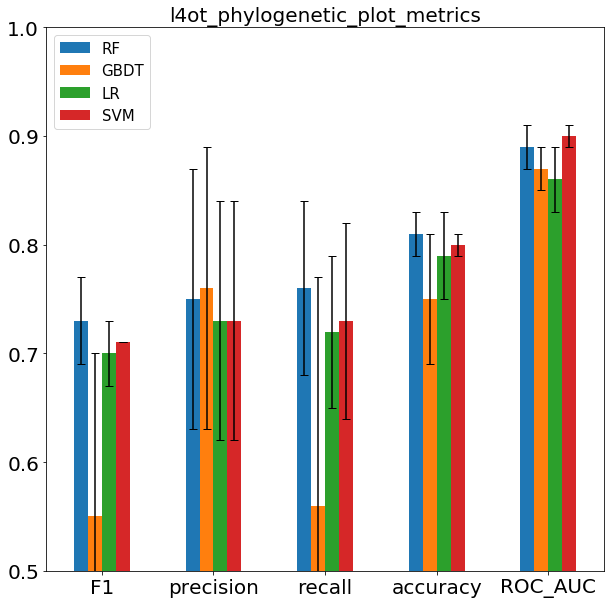

In [32]:
l4ot_phylogenetic_score_mean = pd.DataFrame()
l4ot_phylogenetic_score_sem = pd.DataFrame()
l4ot_phylogenetic_score_dict = {}

#run l4ot using the helper function. Shuffle is turned off
for model_name in ['RF','GBDT','LR','SVM']:
    clf = eval(model_name)
    #set the number of proteins.
    l4ot_phylogenetic_model_score = LPOT(clf,4,shuffle = False)
    
    l4ot_phylogenetic_score_dict[model_name] = l4ot_phylogenetic_model_score
    l4ot_phylogenetic_score_mean[model_name] = l4ot_phylogenetic_model_score.mean()[:-1].astype(float).round(2)
    l4ot_phylogenetic_score_sem[model_name] = l4ot_phylogenetic_model_score.sem().round(2)
    
#print out l4ot-phylogeneticed performance by mean and sem scores
print("\n l4ot-phylogeneticed_score_mean\n",l4ot_phylogenetic_score_mean)
print("\n l4ot-phylogeneticed_sem\n",l4ot_phylogenetic_score_sem)

#plot result by metrics
l4ot_phylogenetic_plot_metrics = l4ot_phylogenetic_score_mean.plot(kind = 'bar', ylim = (0.5,1),
                                                rot = 0, stacked = False,
                                                yerr = l4ot_phylogenetic_score_sem, capsize=4,
                                                figsize = (10,10), fontsize = 20)
plt.legend(loc=2, prop={'size': 15})
plt.title('l4ot_phylogenetic_plot_metrics',fontsize = 20)
plt.savefig(img_dir + "l4ot_phylogenetic_plot_metrics.png")

#### Leave four out randomly 


 Shuffle is On,
 Starting prediction
Model: RandomForestClassifier, test set ['1a2', '3a2', '1b15', 'pmi26']
Model: RandomForestClassifier, test set ['1a1', 'pmi28', '3wuy', '1a27']
Model: RandomForestClassifier, test set ['1a8', '2a6', '1b16', '1a17']

 Shuffle is On,
 Starting prediction
Model: GradientBoostingClassifier, test set ['1b15', '2a6', 'pmi28', '1a2']
Model: GradientBoostingClassifier, test set ['1a8', '1a1', '3a2', '1a17']
Model: GradientBoostingClassifier, test set ['1a27', 'pmi26', '3wuy', '1b16']

 Shuffle is On,
 Starting prediction
Model: LogisticRegression, test set ['pmi28', 'pmi26', '1a1', '1b15']
Model: LogisticRegression, test set ['1a27', '1a8', '2a6', '1b16']
Model: LogisticRegression, test set ['1a17', '1a2', '3a2', '3wuy']

 Shuffle is On,
 Starting prediction
Model: SVC, test set ['1a1', '1a2', '1a8', 'pmi28']
Model: SVC, test set ['1a17', '1a27', 'pmi26', '3wuy']
Model: SVC, test set ['1b16', '1b15', '2a6', '3a2']

 l4ot-random_score_mean
              RF

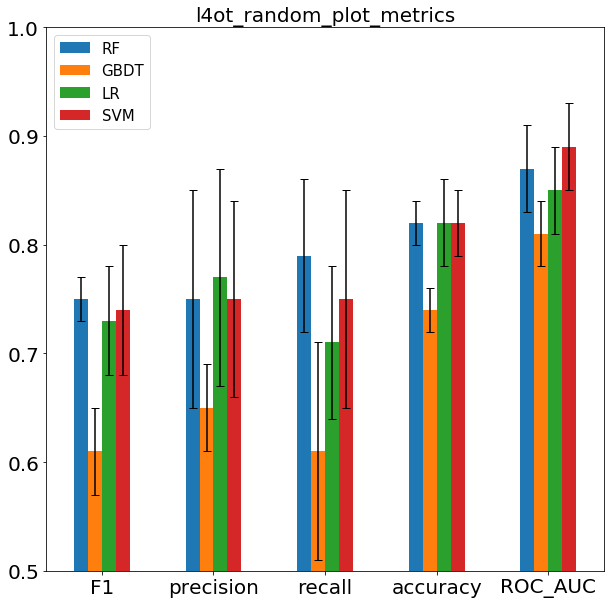

In [33]:
l4ot_random_score_mean = pd.DataFrame()
l4ot_random_score_sem = pd.DataFrame()
l4ot_random_score_dict = {}

for model_name in ['RF','GBDT','LR','SVM']:
    clf = eval(model_name)
    #set the number of proteins.
    l4ot_random_model_score = LPOT(clf,4,shuffle = True)
    
    l4ot_random_score_dict[model_name] = l4ot_random_model_score
    l4ot_random_score_mean[model_name] = l4ot_random_model_score.mean()[:-1].astype(float).round(2)
    l4ot_random_score_sem[model_name] = l4ot_random_model_score.sem().round(2)
    
#print out l4ot-randomed performance by mean and sem scores
print("\n l4ot-random_score_mean\n",l4ot_random_score_mean)
print("\n l4ot-random_sem\n",l4ot_random_score_sem)

#plot result by metrics
l4ot_random_plot_metrics = l4ot_random_score_mean.plot(kind = 'bar', ylim = (0.5,1),
                                                rot = 0, stacked = False,
                                                yerr = l4ot_random_score_sem, capsize=4,
                                                figsize = (10,10), fontsize = 20)
plt.legend(loc=2, prop={'size': 15})
plt.title('l4ot_random_plot_metrics',fontsize = 20)
plt.savefig(img_dir + "l4ot_random_plot_metrics.png")

In [34]:
#inspect the performance of each classifier
l4ot_phylogenetic_score_dict['RF']
l4ot_random_score_dict['RF']

,F1,precision,recall,accuracy,ROC_AUC,confusion_matrix
1a2_3a2_1b15_pmi26,0.760000,0.655172,0.904762,0.8500,0.917272,"[[49, 10], [2, 19]]"
1a1_pmi28_3wuy_1a27,0.786885,0.960000,0.666667,0.8375,0.893624,"[[43, 1], [12, 24]]"
1a8_2a6_1b16_1a17,0.711864,0.636364,0.807692,0.7875,0.790954,"[[42, 12], [5, 21]]"


### Run leave six out phylogenetically and randomly
**6 out of 12** proteins will be used as test set.
Data will be separated into **2** folds.

#### Leave six out phylogenetically


 Shuffle is Off,
 Starting prediction
Model: RandomForestClassifier, test set ['1a1', '1a2', '1a8', 'pmi28', '1a17', '1a27']
Model: RandomForestClassifier, test set ['pmi26', '3wuy', '1b16', '1b15', '2a6', '3a2']

 Shuffle is Off,
 Starting prediction
Model: GradientBoostingClassifier, test set ['1a1', '1a2', '1a8', 'pmi28', '1a17', '1a27']
Model: GradientBoostingClassifier, test set ['pmi26', '3wuy', '1b16', '1b15', '2a6', '3a2']

 Shuffle is Off,
 Starting prediction
Model: LogisticRegression, test set ['1a1', '1a2', '1a8', 'pmi28', '1a17', '1a27']
Model: LogisticRegression, test set ['pmi26', '3wuy', '1b16', '1b15', '2a6', '3a2']

 Shuffle is Off,
 Starting prediction
Model: SVC, test set ['1a1', '1a2', '1a8', 'pmi28', '1a17', '1a27']
Model: SVC, test set ['pmi26', '3wuy', '1b16', '1b15', '2a6', '3a2']

 l6ot-phylogeneticed_score_mean
              RF  GBDT    LR   SVM
F1         0.77  0.67  0.72  0.71
precision  0.76  0.71  0.77  0.69
recall     0.79  0.63  0.68  0.73
accuracy   0

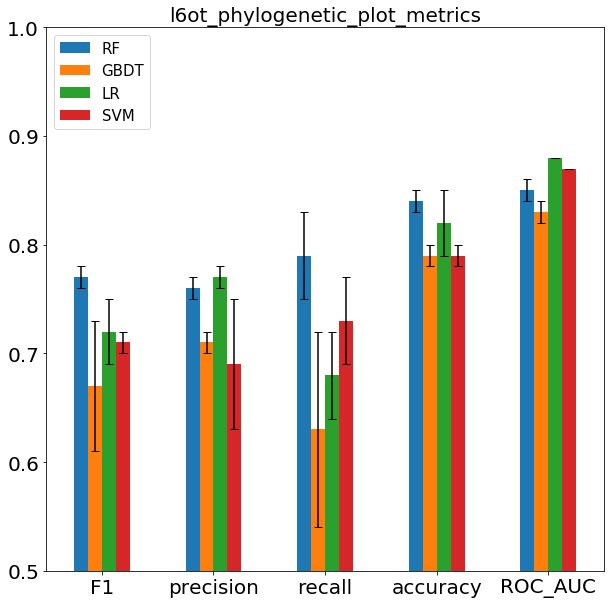

In [35]:
l6ot_phylogenetic_score_mean = pd.DataFrame()
l6ot_phylogenetic_score_sem = pd.DataFrame()
l6ot_phylogenetic_score_dict = {}

#run l6ot using the helper function. Shuffle is turned off
for model_name in ['RF','GBDT','LR','SVM']:
    clf = eval(model_name)
    #set the number of proteins.
    l6ot_phylogenetic_model_score = LPOT(clf,6,shuffle = False)
    
    l6ot_phylogenetic_score_dict[model_name] = l6ot_phylogenetic_model_score
    l6ot_phylogenetic_score_mean[model_name] = l6ot_phylogenetic_model_score.mean()[:-1].astype(float).round(2)
    l6ot_phylogenetic_score_sem[model_name] = l6ot_phylogenetic_model_score.sem().round(2)
    
#print out l6ot-phylogeneticed performance by mean and sem scores
print("\n l6ot-phylogeneticed_score_mean\n",l6ot_phylogenetic_score_mean)
print("\n l6ot-phylogeneticed_sem\n",l6ot_phylogenetic_score_sem)

#plot result by metrics
l6ot_phylogenetic_plot_metrics = l6ot_phylogenetic_score_mean.plot(kind = 'bar', ylim = (0.5,1),
                                                rot = 0, stacked = False,
                                                yerr = l6ot_phylogenetic_score_sem, capsize=4,
                                                figsize = (10,10), fontsize = 20)
plt.legend(loc=2, prop={'size': 15})
plt.title('l6ot_phylogenetic_plot_metrics',fontsize = 20)
plt.savefig(img_dir + "l6ot_phylogenetic_plot_metrics.png")

#### Leave six out randomly


 Shuffle is On,
 Starting prediction
Model: RandomForestClassifier, test set ['1a8', '1b15', '1a27', '1a1', '1b16', '1a17']
Model: RandomForestClassifier, test set ['1a2', '3a2', '3wuy', 'pmi28', 'pmi26', '2a6']

 Shuffle is On,
 Starting prediction
Model: GradientBoostingClassifier, test set ['1a27', 'pmi28', '1a17', '1a8', '3wuy', '1b16']
Model: GradientBoostingClassifier, test set ['1b15', '2a6', '3a2', '1a1', '1a2', 'pmi26']

 Shuffle is On,
 Starting prediction
Model: LogisticRegression, test set ['1a17', '1a1', '1b16', '1a27', '3a2', '3wuy']
Model: LogisticRegression, test set ['pmi28', 'pmi26', '2a6', '1a8', '1b15', '1a2']

 Shuffle is On,
 Starting prediction
Model: SVC, test set ['1b16', '1a8', '3wuy', '1a17', '2a6', '3a2']
Model: SVC, test set ['1a1', '1a2', 'pmi26', '1a27', 'pmi28', '1b15']

 l6ot-random_score_mean
              RF  GBDT    LR   SVM
F1         0.73  0.71  0.56  0.66
precision  0.75  0.70  0.70  0.66
recall     0.75  0.75  0.52  0.66
accuracy   0.82  0.79  0

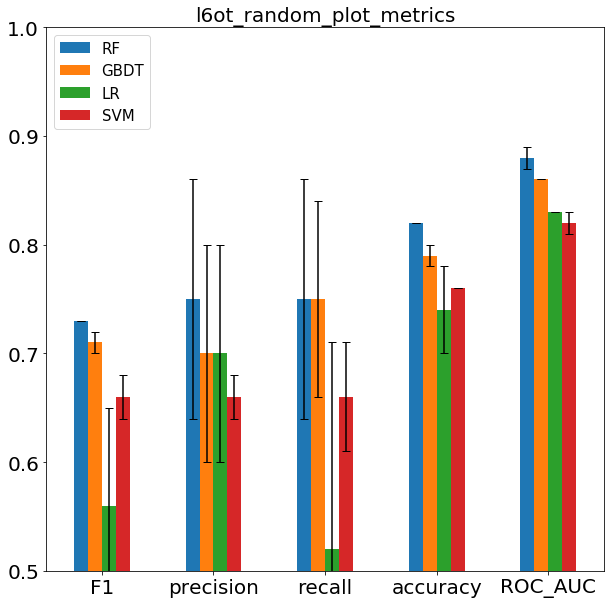

In [36]:
l6ot_random_score_mean = pd.DataFrame()
l6ot_random_score_sem = pd.DataFrame()
l6ot_random_score_dict = {}

for model_name in ['RF','GBDT','LR','SVM']:
    clf = eval(model_name)
    #set the number of proteins.
    l6ot_random_model_score = LPOT(clf,6,shuffle = True)
    
    l6ot_random_score_dict[model_name] = l6ot_random_model_score
    l6ot_random_score_mean[model_name] = l6ot_random_model_score.mean()[:-1].astype(float).round(2)
    l6ot_random_score_sem[model_name] = l6ot_random_model_score.sem().round(2)
    
#print out l6ot-randomed performance by mean and sem scores
print("\n l6ot-random_score_mean\n",l6ot_random_score_mean)
print("\n l6ot-random_sem\n",l6ot_random_score_sem)

#plot result by metrics
l6ot_random_plot_metrics = l6ot_random_score_mean.plot(kind = 'bar', ylim = (0.5,1),
                                                rot = 0, stacked = False,
                                                yerr = l6ot_random_score_sem, capsize=4,
                                                figsize = (10,10), fontsize = 20)
plt.legend(loc=2, prop={'size': 15})
plt.title('l6ot_random_plot_metrics',fontsize = 20)
plt.savefig(img_dir + "l6ot_random_plot_metrics.png")

In [37]:
#inspect the performance of each classifier
l6ot_phylogenetic_score_dict['RF']
l6ot_random_score_dict['RF']

,F1,precision,recall,accuracy,ROC_AUC,confusion_matrix
1a8_1b15_1a27_1a1_1b16_1a17,0.738095,0.645833,0.861111,0.816667,0.862599,"[[67, 17], [5, 31]]"
1a2_3a2_3wuy_pmi28_pmi26_2a6,0.731707,0.857143,0.638298,0.816667,0.888954,"[[68, 5], [17, 30]]"


### Compare the performance from LOOT to L6OT for random forest

In [38]:
random_mean_lst = ['loot_score_mean'] + ['l'+ i + 'ot_random_score_mean' for i in '2346']
random_sem_lst = ['loot_score_sem'] + ['l'+ i + 'ot_random_score_sem' for i in '2346']

phylogenetic_mean_lst = ['loot_score_mean'] + ['l'+ i + 'ot_phylogenetic_score_mean' for i in '2346']
phylogenetic_sem_lst = ['loot_score_sem'] + ['l'+ i + 'ot_phylogenetic_score_sem' for i in '2346']

clf = 'RF'
random_mean_rf = pd.DataFrame()
random_sem_rf = pd.DataFrame()
phylogenetic_mean_rf = pd.DataFrame()
phylogenetic_sem_rf = pd.DataFrame()

for a,b,c,d in zip(random_mean_lst,random_sem_lst,phylogenetic_mean_lst,phylogenetic_sem_lst):
    title = a[:4]
    random_mean_rf[title] = eval(a)['RF']
    random_sem_rf[title] = eval(b)['RF']
    
    phylogenetic_mean_rf[title] = eval(c)['RF']
    phylogenetic_sem_rf[title] = eval(d)['RF']

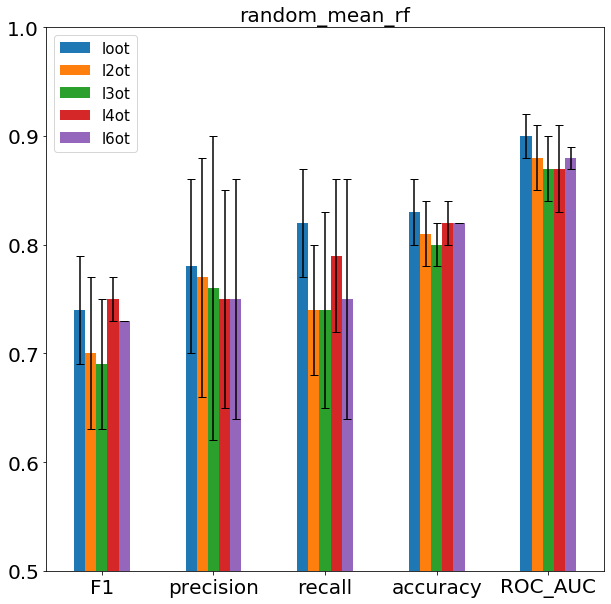

In [39]:
#plot random LPOT performance for RF 
random_mean_rf.plot(kind = 'bar', ylim = (0.5,1),
                    rot = 0, stacked = False,
                    yerr = random_sem_rf, capsize=4,
                    figsize = (10,10), fontsize = 20)

plt.legend(loc=2, prop={'size': 15})
plt.title('random_mean_rf',fontsize = 20)
plt.savefig(img_dir + "random_mean_rf.png")

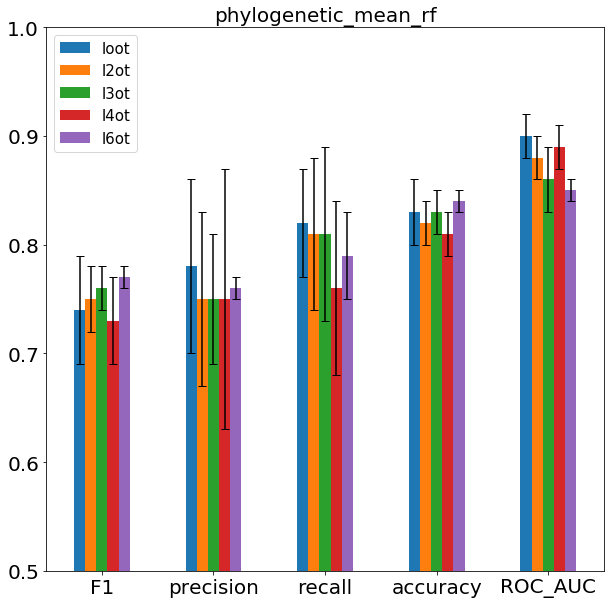

In [40]:
#plot phylogenetic LPOT performance for RF
phylogenetic_mean_rf.plot(kind = 'bar', ylim = (0.5,1),
                    rot = 0, stacked = False,
                    yerr = phylogenetic_sem_rf, capsize=4,
                    figsize = (10,10), fontsize = 20)
plt.legend(loc=2, prop={'size': 15})
plt.title('phylogenetic_mean_rf',fontsize = 20)
plt.savefig(img_dir + "phylogenetic_mean_rf.png")

## Feature importance

In [41]:
#separate descriptors by category

#e.g, 61 descriptors in total after removing highly correlated descriptors (90%)
X_main = df_scaled.iloc[:,9:]
y = df_scaled['cutoff_2'].apply(lambda x: 0 if x == 'inactive' else 1)
y.to_numpy()

#7 docking descriptors
docking = df_scaled.iloc[:,9:16]
#8 QM descriptors
QM = df_scaled.iloc[:,16:24]
#37 MOE descriptors
MOE = df_scaled.iloc[:,24:-9]
#9 prot_dcal descriptors
prot_dcal = df_scaled.iloc[:,-9:]

### Plot feature importance for tree-based methods
e.g. Random Forest


### Calculate feature importance for each category

In [42]:
#map descriptor labels to categories.
QM_renamed = QM.rename(columns = lambda x:'QM')
docking_renamed = docking.rename(columns = lambda x:'Docking')
MOE_renamed = MOE.rename(columns = lambda x:'MOE')
prot_dcal_renamed = prot_dcal.rename(columns = lambda x:'ProtDCal')

#concatenate categorized dataframes
X_renamed = pd.concat([docking_renamed,QM_renamed,MOE_renamed,prot_dcal_renamed],axis = 1)
y = df_scaled['cutoff_2'].apply(lambda x: 0 if x == 'inactive' else 1)
#y.to_numpy()

feat_imp_count = pd.DataFrame(index = ['QM','Docking','MOE','ProtDCal'])
feat_imp_data = pd.DataFrame()

#create a dict that store the variable importance data with descriptor labels
feat_dict = {}
#create a dict that store the variable importance data with categories
feat_dict_renamed = {}

X = df_scaled.iloc[:,9:]

#making 20 random runs.
for i in range(20):
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.20, random_state = i)
    clf = RF
    clf.fit(X_train, y_train.ravel())
    featimp = pd.Series(clf.feature_importances_, index = X.columns).sort_values(ascending = False)
    featimp_renamed = pd.Series(clf.feature_importances_, index = X_renamed.columns).sort_values(ascending = False)
    
    feat_dict[i] = featimp.apply(lambda x: x/featimp.max()*100).head(10)
    feat_dict_renamed[i] = featimp_renamed.apply(lambda x: x/featimp.max()*100).head(10).sort_values(ascending = False)
    
    #print(feat_dict[i],'\n') #print out feature importance of each run.
    
    feat_imp_data[i] = featimp.apply(lambda x: x/featimp.max()*100).head(10).index
    feat_imp_count[i] = featimp_renamed.apply(lambda x: x/featimp_renamed.max()*100).head(10).index.value_counts()
    
feat_imp_count.fillna(0)

feat_imp_data

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,fa_atr,npr1,vsurf_A,HBd,vsurf_A,ASA_P,npr1,fa_atr,vsurf_A,vsurf_A,vsurf_A,W(F),ASA_P,fa_atr,vsurf_A,ASA_P,vsurf_A,npr1,ASA_P,npr1
1,npr1,HBd,vsa_hyd,fa_atr,fa_atr,vsa_acc,ASA_P,vsurf_A,ASA_P,npr1,HBd,npr1,npr1,W(F),fa_elec,vsurf_A,npr1,ASA_P,vsurf_A,fa_atr
2,fa_elec,ASA_P,ASA_P,npr1,vsa_hyd,vsurf_A,W(F),vsa_acc,fa_atr,fa_atr,W(F),vsurf_A,W(F),DGel,fa_atr,npr1,ASA_P,vsurf_A,npr1,vsurf_A
3,HBd,fa_atr,fa_elec,W(F),ASA_P,npr1,vsurf_A,npr1,W(F),W(F),vsa_acc,fa_atr,CASA-,ASA_P,W(F),vsa_acc,HBd,vsa_hyd,vsa_acc,ASA_P
4,vsurf_A,fa_elec,h_logD,ASA_P,hbond_sc,fa_atr,vsa_acc,HBd,hbond_sc,interface_delta_X,DGel,hbond_bb_sc,h_logD,hbond_sc,npr1,fa_atr,Gw(F),fa_atr,hbond_sc,HBd
5,ASA_P,vsurf_A,fa_atr,fa_elec,HBd,W(F),hbond_bb_sc,interface_delta_X,npr1,ASA_P,ASA_P,HBd,fa_atr,fa_elec,vsa_acc,DGel,fa_atr,W(F),W(F),DGel
6,hbond_sc,interface_delta_X,npr1,hbond_bb_sc,npr1,vsa_hyd,fa_atr,W(F),Q_RPC+,fa_rep,vsa_hyd,DGel,DGel,vsurf_A,hbond_sc,W(F),DGel,hbond_sc,fa_atr,fa_sol
7,fa_sol,W(F),interface_delta_X,Gw(F),W(F),hbond_sc,fa_elec,MK-C,HOMO,vsa_acc,fa_atr,W(U),vsurf_A,fa_rep,ASA_P,HBd,fa_sol,hbond_bb_sc,fa_rep,vsa_acc
8,vsa_acc,DGel,vsa_acc,DGel,fa_elec,hbond_bb_sc,fa_sol,DGel,hbond_bb_sc,DGel,fa_sol,fa_rep,fa_elec,vsa_acc,DGel,hbond_sc,W(F),MK-C,HBd,interface_delta_X
9,W(F),vsa_acc,hbond_sc,hbond_sc,interface_delta_X,CASA-,h_logD,fa_elec,CASA-,vsa_hyd,fa_elec,DGc(F),vsa_acc,interface_delta_X,W(U),vsa_hyd,W(U),fa_elec,interface_delta_X,fa_elec


In [43]:
#save the feature importance data from the 20 runs.
pd.DataFrame.from_dict(feat_dict).to_csv(img_dir + '20_run_features.csv')

### Plot the results from the 20 runs.

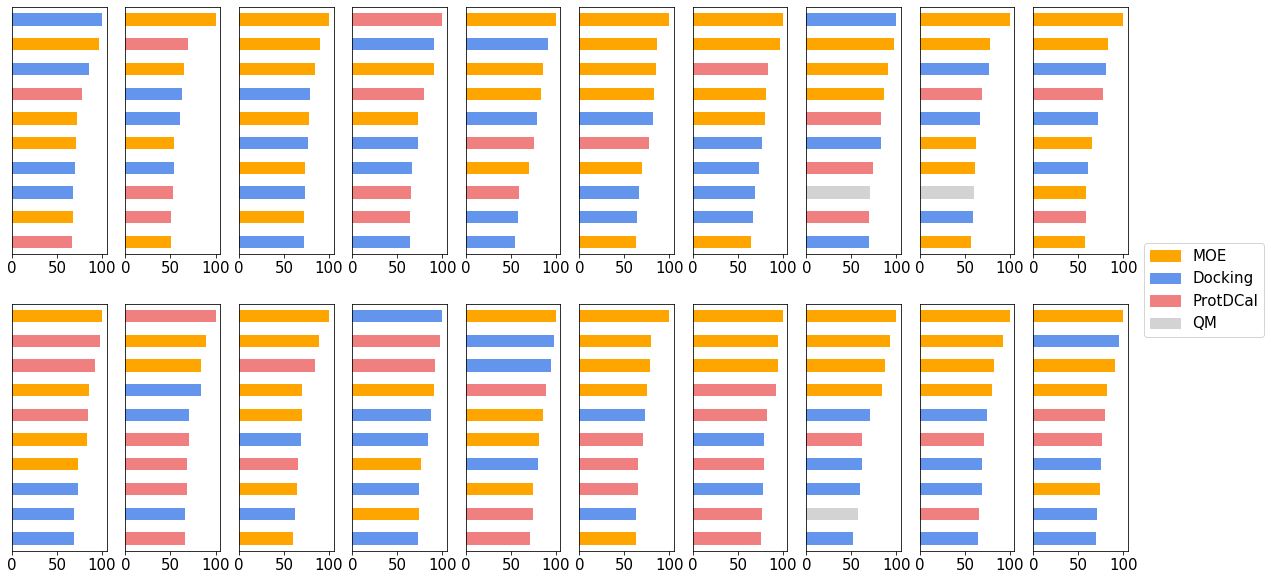

In [44]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

#set index mapping
colors = {'MOE': 'orange',
          'Docking': 'cornflowerblue',
          'ProtDCal': 'lightcoral',
          'QM': 'lightgrey'}

#set size and height of the figure
fig = plt.figure(figsize=(20, 10)) 

for i in range(20):
    ax = fig.add_subplot(2,10,i+1)
    data = feat_dict_renamed[i].sort_values(ascending = True)
    data.plot(kind = 'barh',color=data.index.map(colors),fontsize = 15)
    ax.get_yaxis().set_visible(False)

#create legend
hand_lst = []
for lab,col in colors.items():
    hand_lst.append(mpatches.Patch(color=col, label=lab))
    
fig.legend(handles = hand_lst,loc='right',fontsize = 15)
plt.show
plt.savefig(img_dir + "top_10_features_in_20_runs.png")

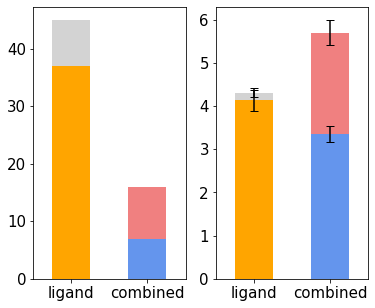

In [45]:
#Calculate the average number in each category over the 20 runs.
test_mean = feat_imp_count.fillna(0).mean(axis=1)
test_sem = feat_imp_count.fillna(0).sem(axis=1)
#test_mean.plot(kind = 'bar',yerr = test_sem, capsize=10, rot = 0,
#               figsize = (5,5), fontsize = 15, color=test_mean.index.map(colors))

test_mean_df = pd.DataFrame({'ligand': test_mean[[0,2]],'combined': test_mean[[1,3]]})
test_err_df = pd.DataFrame({'ligand': test_sem[[0,2]],'combined': test_sem[[1,3]]})

feat_num = test_mean_df.copy()
feat_num.loc['MOE']['ligand'] = MOE.shape[1]
feat_num.loc['QM']['ligand'] = QM.shape[1]
feat_num.loc['Docking']['combined'] = docking.shape[1]
feat_num.loc['ProtDCal']['combined'] = prot_dcal.shape[1]

fig, axes = plt.subplots(figsize=(6,5),nrows=1, ncols=2)

#total number of descriptors used for ML
feat_num.transpose().plot(ax=axes[0], kind = 'bar',rot = 0, stacked = True, 
                          color=feat_num.index.map(colors),capsize=4, 
                          legend = False, fontsize = 15)
#average number in each category 
test_mean_df.transpose().plot(ax=axes[1], kind = 'bar',
                              rot = 0, stacked = True, color=test_mean_df.index.map(colors),
                              yerr = test_err_df.transpose(), capsize=4, legend = False,
                              fontsize = 15)

plt.savefig(img_dir + "features_20_runs.png")

plt.show()